# Resolviendo ecuaciones diferenciales con FEniCS

![](./plate3d.png)

### Juan Luis Cano Rodríguez <hello@juanlu.space>
### Pontificia Universidad Católica del Perú, Lima, 2017-05-16

# Índice

1. Introducción
2. Arquitectura
3. Instalación
4. Ejemplo básico
5. Problemas más complejos
6. Recursos y alternativas
7. Conclusiones
8. Q & A

# 1. Introducción

## ¿Qué es FEniCS?

* FEniCS es una colección de bibliotecas libres para la **solución de ecuaciones diferenciales por el método de los elementos finitos**

![FEniCS](img/fenics_banner.svg)

* La ecuación se especifica en forma variacional utilizando un lenguaje simbólico
* FEniCS automatiza la discretización de la ecuación diferencial
* Para la resolución del sistema utiliza *solvers* establecidos como UMFPACK o PETSc
* Enfoque muy matemático: artesanal y potente

## Método de los elementos finitos

* Método numérico para la **aproximación de ecuaciones diferenciales**
* Se particiona el espacio en subdominios llamados **elementos**, y en ellos se aproximan las ecuaciones

![FEM](fem.png)

## Historia

* DOLFIN 0.2.0 en 2002: inicialmente una sola biblioteca en C++
* En 2003 nace el proyecto FEniCS y se empieza a diversificar
* Se van introduciendo componentes, *algunos se retiran*
* Se libera FEniCS 1.0 en diciembre de 2011
* Proyecto NumFOCUS en noviembre de 2016
* **FEniCS 2017.1 el 9 de mayo de 2017**

# 2. Arquitectura

![Proyecto FEniCS](fenics_project_updated.png)

## Unified Form Language

![UFL-FFC-UFC](ufl-ffc-ufc.png)

* En FEniCS, las formas variacionales se expresan mediante un **lenguaje simbólico**
* **UFL** (Unified Form Language) es este lenguaje
* Se pretende compilar esas formas para que se evalúen más rápido
* **UFC** (Unified Form Compiler) es el código C++ generado
* **FFC** (FEniCS Form Compiler) es quien se encarga de esta compilación

## FFC

* FFC toma la forma variacional expresada en UFL
* **FIAT** (FInite Element Tabulator) genera los elementos finitos sobre el mallado
* **Instant** es una interfaz simplificada para incrustar expresiones C++ en Python que se compilan con SWIG

# 3. Instalación

```
$ conda install fenics -c conda-forge
```

_Y ya está :)_

# 4. Ejemplo básico

Resolver **la ecuación de Poisson**

$$ -\nabla^2 u = f \quad u \in \Omega,$$

en el dominio $\Omega = [0, 1] \times [0, 1] \in \mathbb{R}^2$, siendo $f = 100\exp(-((x - 0.5)^2 + (y - 0.5)^2) / 0.02)$ el término forzante

y sometida a la condición de contorno $u = \sin{\left(2 \pi x^2\right)}$ en $\partial\Omega$.

## Calentando motores

In [1]:
%matplotlib inline

from fenics import *

## Dominio y mallado

* En FEniCS tenemos varias funciones para crear dominios sencillos
* En nuestro caso, queremos `UnitSquareMesh`
* Tenemos que especificar el número de elementos de la partición

In [2]:
mesh = UnitSquareMesh(8, 6)
#mesh

## Espacios de funciones

* En FEM, las soluciones a las ecuaciones se buscan en **espacios de Sobolev**
* Su elección es importante: condiciona el error de la solución
* En FEniCS hay soporte completo para varios:

![Elementos](elements.png)

In [3]:
supported_elements

['Brezzi-Douglas-Fortin-Marini',
 'Brezzi-Douglas-Marini',
 'BrokenElement',
 'Bubble',
 'Crouzeix-Raviart',
 'Discontinuous Lagrange',
 'Discontinuous Raviart-Thomas',
 'Discontinuous Taylor',
 'EnrichedElement',
 'Gauss-Legendre',
 'Gauss-Lobatto-Legendre',
 'HDiv Trace',
 'Hellan-Herrmann-Johnson',
 'Lagrange',
 'Nedelec 1st kind H(curl)',
 'Nedelec 2nd kind H(curl)',
 'NodalEnrichedElement',
 'Raviart-Thomas',
 'Regge',
 'TensorProductElement']

Para nuestro problema concreto, vamos a utilizar los clásicos **elementos polinómicos de Lagrange de orden 1**:

In [4]:
V = FunctionSpace(mesh, 'Lagrange', 1)

u = TrialFunction(V)
v = TestFunction(V)

In [5]:
u

In [6]:
v

## Condiciones de contorno

* De dos tipos: **naturales** y **esenciales**
* Tenemos que definir sobre qué contorno las aplicamos
* Las primeras se crean usando `DirichletBC`:

In [7]:
def boundary(x, on_boundary):
    """El parámetro on_boundary es verdadero si el punto está
    sobre el contorno. Podríamos hacer otro tipo de comprobaciones,
    pero en este caso basta con devolver este mismo valor.

    """
    return on_boundary

u0 = Expression('sin(2 * pi * x[0] * x[0])', degree=2)
bc = DirichletBC(V, u0, boundary)

## Formulación variacional

* Reescribir la ecuación en forma débil es el paso más importante
* Buscamos expresiones de este tipo:

$$a(u, v) = L(v)$$

* Gracias a UFL, la traducción es directa

En nuestro caso:

$$-\nabla^2 u = f$$

$$\begin{align}
-\int_\Omega (\nabla^2 u) v dx & = \int_\Omega \nabla u \cdot \nabla v dx - \oint_{\partial\Omega} \frac{\partial u}{\partial n} v ds \\
& = \int_\Omega \nabla u \cdot \nabla v dx
\end{align}$$

$$\boxed{\displaystyle \int_\Omega \nabla u \cdot \nabla v dx = \int_\Omega f v dx}$$

Y ahora, la escribimos en Python:

In [8]:
f = Expression("100 * exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2)
a = inner(nabla_grad(u), nabla_grad(v)) * dx  # Miembro izquierdo
L = f * v * dx

### Resolvemos el sistema

* FEniCS tiene interfaces a multitud de solvers
* Necesitamos una función sobre la que escribir la solución
* En el caso más sencillo, llamamos simplemente a la función `solve`:

In [9]:
u = Function(V)
solve(a == L, u, bc)

max(abs(u.vector().array()))  # Array de valores numéricos

1.7801108583256924

## Los colorines

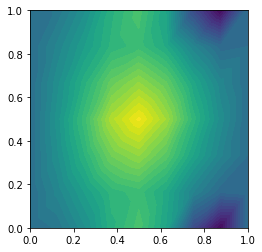

In [10]:
plot(u)

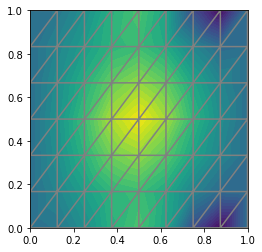

In [11]:
plot(u)
plot(mesh)

In [12]:
from IPython.display import HTML

In [13]:
HTML(X3DOM().html(u))

# 5. Problemas más complejos

* La formulación variacional puede ser bastante complicada\*

$$ \begin{split}\sum_{K \in \mathcal{T}} \int_{K} \nabla^{2} u \nabla^{2} v \, dx \
- \int_{\Gamma} \left<\nabla^{2} u \right>  [\!\![ \nabla v ]\!\!] \, ds
- \int_{\Gamma}[\!\![  \nabla u ]\!\!]  \left<\nabla^{2} v \right>  \, ds
+ \int_{\Gamma} \frac{\alpha}{h}[\!\![ \nabla u ]\!\!]  [\!\![ \nabla v ]\!\!]  \, ds
= \int_{\Omega} vf \, dx \quad \forall \ v \in V\end{split} $$

\*<small>[Formulación con funciones *penalty* para la ecuación biharmónica](http://fenicsproject.org/documentation/dolfin/1.5.0/python/demo/documented/biharmonic/python/documentation.html)</small>

* Para formulaciones mixtas, se pueden crear espacios de funciones combinando varios

* Se puede trocear el dominio y aplicar condiciones naturales y esenciales

* A veces es necesario especificar los parámetros del *solver* para mejorar el proceso de la solución

* Para geometrías más complicadas hay que acudir a programas externos, comom **Gmsh**

# 6. Recursos y alternativas

* Introducción en Pybonacci: http://pybonacci.org/2015/01/20/fenics-resolucion-de-ecuaciones-diferenciales-en-python/
* Libro de FEniCS: http://fenicsproject.org/book/
* FEniCS Q&A: http://fenicsproject.org/qa/

Existen otras soluciones para resolver ecuaciones diferenciales con Python:

* **SfePy**, también por elementos finitos, enfoque más estructural
* **FiPy**, volúmenes finitos
* **Clawpack**, volúmenes finitos orientado a ecuaciones hiperbólicas

# Conclusiones

* FEniCS es un proyecto muy ambicioso y sus bibliotecas muy potentes
* Instalarlo ya no es un problema ;)
* La dificultad está en la parte matemática
* Libro un poco desactualizado **¡nueva edición próximamente!**
* ¡Esto es solo la punta del iceberg!